# Analyzing the Gap Between Actual and Requested Temperature

### Data Loading & Preprocessing

In [1]:
import pandas as pd

In [54]:
pivotted = pd.read_csv(r'C:\Users\achopra8\Documents\BDD Climate Control\2019f150VIN1FTEW1C53KFB01079_pivotted_finaltripflags.csv')
pivotted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183491 entries, 0 to 183490
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   cvdcus_timestamp_s_3   183491 non-null  object 
 1   epoch                  183491 non-null  float64
 2   epoch_diff             183490 non-null  float64
 3   trip                   183491 non-null  int64  
 4   BrkTot_Tq_Actl         176228 non-null  float64
 5   HvacBlwrFront_D_Stat   31228 non-null   object 
 6   Veh_V_ActlEng          169285 non-null  float64
 7   GearLvrPos_D_Actl      169864 non-null  object 
 8   ApedPos_Pc_ActlArb     177919 non-null  float64
 9   EngAout_N_Actl         177919 non-null  float64
 10  HvacEvap_Te_Actl       128521 non-null  float64
 11  HvacEvap_Te_Rq         128521 non-null  float64
 12  HvacAirCond_B_Rq       128521 non-null  object 
 13  BattULo_U_Actl         170255 non-null  float64
 14  AirCondFluidHi_P_Actl  69554 non-nul

When constructing the pivot table, we had to aggregate by mode for categorical features. For some timestamps, two modes were present, creating multiple values (e.g. ['Step8' 'Step9'] and ['Step4' 'Step5'] for "CoolantFanStepAct"). To deal with this, we will replace these values with the first mode.

In [3]:
pivotted = pivotted.replace({r"\['(\w+)'.*": r'\1'}, regex=True)

Let's impute missing values by using a combination of forward filling for features with at least 50% non-null values and KNN for the remaining features.

In [4]:
from sklearn.impute import KNNImputer
def make_dummies_and_impute(trip):
    cols_to_ffill = ['BrkTot_Tq_Actl', 'Veh_V_ActlEng', 'GearLvrPos_D_Actl','ApedPos_Pc_ActlArb', 'EngAout_N_Actl', 'HvacEvap_Te_Actl', 'HvacEvap_Te_Rq', 'HvacAirCond_B_Rq', 'BattULo_U_Actl', 'AirAmb_Te_ActlFilt', 'Outside_Air_Temp_Stat', 'OdometerMasterValue', 'VehLong2_A_Actl', 'temp_gap']
    trip = trip[trip.columns[4:]]
    trip = trip.drop(['Ignition_Status', 'RearPassWindowPos', 'DriverWindowPosition','PassWindowPosition'], axis=1) # ignition_status only needed to define trips; window position signals are bad quality so we will leave them out for now
    trip[cols_to_ffill] = trip[cols_to_ffill].fillna(method='ffill')
    imputer = KNNImputer(weights='distance')
    trip_one_hot_encoded = pd.get_dummies(trip)
    trip = pd.DataFrame(imputer.fit_transform(trip_one_hot_encoded), index=trip.index, columns=trip_one_hot_encoded.columns)
    return trip_one_hot_encoded

pivotted_f = [make_dummies_and_impute(pivotted[pivotted['trip'] == trip]) for trip in pivotted['trip'].unique()]
pivotted_f = pd.concat(pivotted_f)
pivotted_f = pd.concat([pivotted[pivotted.columns[:4]], pivotted_f], axis=1)
pivotted_f = pivotted_f.fillna(method='ffill').fillna(method='bfill') # remaining nans

In [6]:
pivotted_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183491 entries, 0 to 183490
Data columns (total 62 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   cvdcus_timestamp_s_3                183491 non-null  object 
 1   epoch                               183491 non-null  float64
 2   epoch_diff                          183491 non-null  float64
 3   trip                                183491 non-null  int64  
 4   BrkTot_Tq_Actl                      183491 non-null  float64
 5   Veh_V_ActlEng                       183491 non-null  float64
 6   ApedPos_Pc_ActlArb                  183491 non-null  float64
 7   EngAout_N_Actl                      183491 non-null  float64
 8   HvacEvap_Te_Actl                    183491 non-null  float64
 9   HvacEvap_Te_Rq                      183491 non-null  float64
 10  BattULo_U_Actl                      183491 non-null  float64
 11  AirCondFluidHi_P_Actl     

Now, let's reverse the one-hot encoding.

In [7]:
categorical_vars = ['HvacBlwrFront_D_Stat', 'GearLvrPos_D_Actl', 'HvacAirCond_B_Rq', 'CoolantFanStepAct']
for var in categorical_vars:
    all_cols = pivotted_f.columns[17:]
    rel_cols = [col for col in all_cols if col.startswith(var) ]
    pivotted_f[var] = pivotted_f[rel_cols].idxmax(axis=1)

for var in categorical_vars:
    pivotted_f[var] = pivotted_f[var].map(lambda x: x[(x.index(var) + len(var) + 1):])

pivotted_f = pivotted_f[list(pivotted_f.columns[:17]) + list(pivotted_f.columns[-4:])]

Let's subset our data further by only looking at intervals where the AC is on.

In [8]:
pivotted_f = pivotted_f[pivotted_f['HvacAirCond_B_Rq'] == 'Yes'].reset_index(drop=True) # AC on
pivotted_f['epoch_diff'] = pivotted_f['epoch'].diff() # recalc epoch diff since some trips now 

In [130]:
#pivotted_f.to_csv(r'C:\Users\achopra8\Documents\BDD Climate Control\2019f150VIN1FTEW1C53KFB01079_pivotted_finaltripflags_imputed.csv', index=False)

### Descriptive Statistics

In [9]:
from scipy.stats import describe
import matplotlib.pyplot as plt
import seaborn as sns

**Gap Distribution**

DescribeResult(nobs=157856, minmax=(-7.875, 39.5), mean=0.6235503700773787, variance=12.469305638432711, skewness=3.5112925125654377, kurtosis=20.875178230383277)


Text(0, 0.5, 'Density')

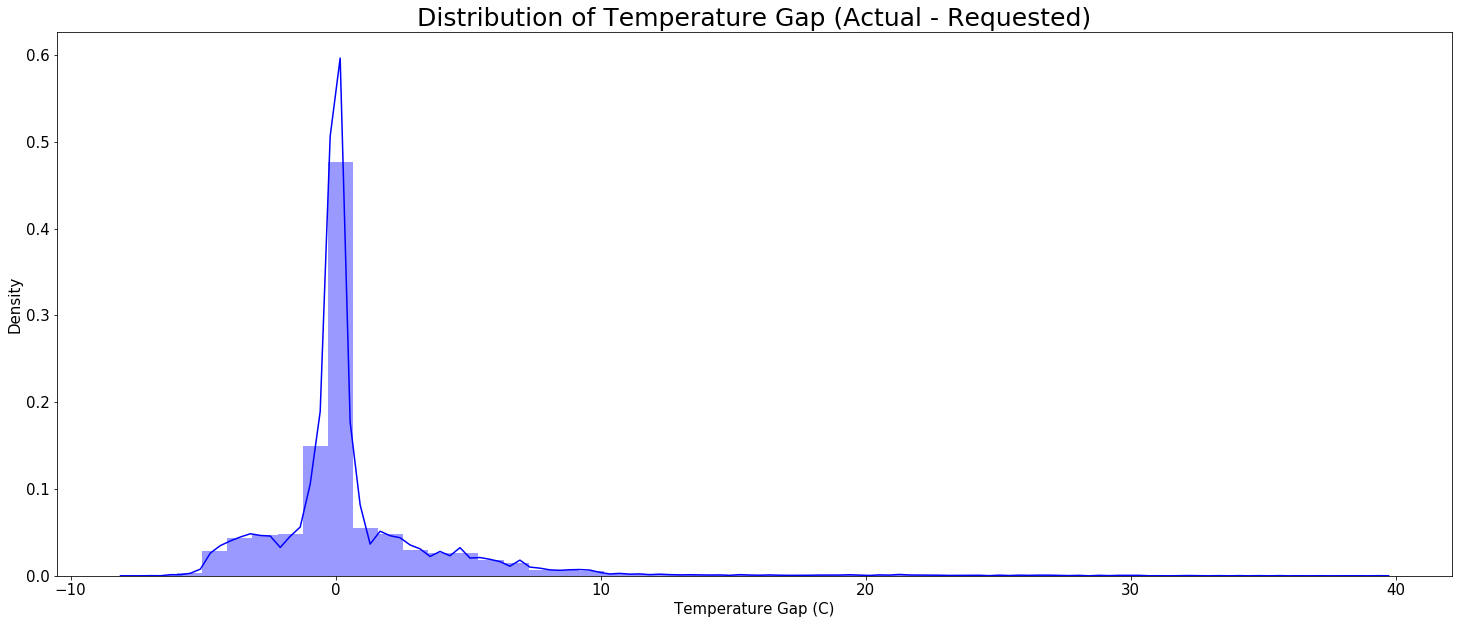

In [10]:
print(describe(pivotted_f['temp_gap'].dropna()))
fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(pivotted_f['temp_gap'], color='Blue')
plt.title('Distribution of Temperature Gap (Actual - Requested)', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Temperature Gap (C)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)

**Visualizing the Gap**

C:\Users\achopra8\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


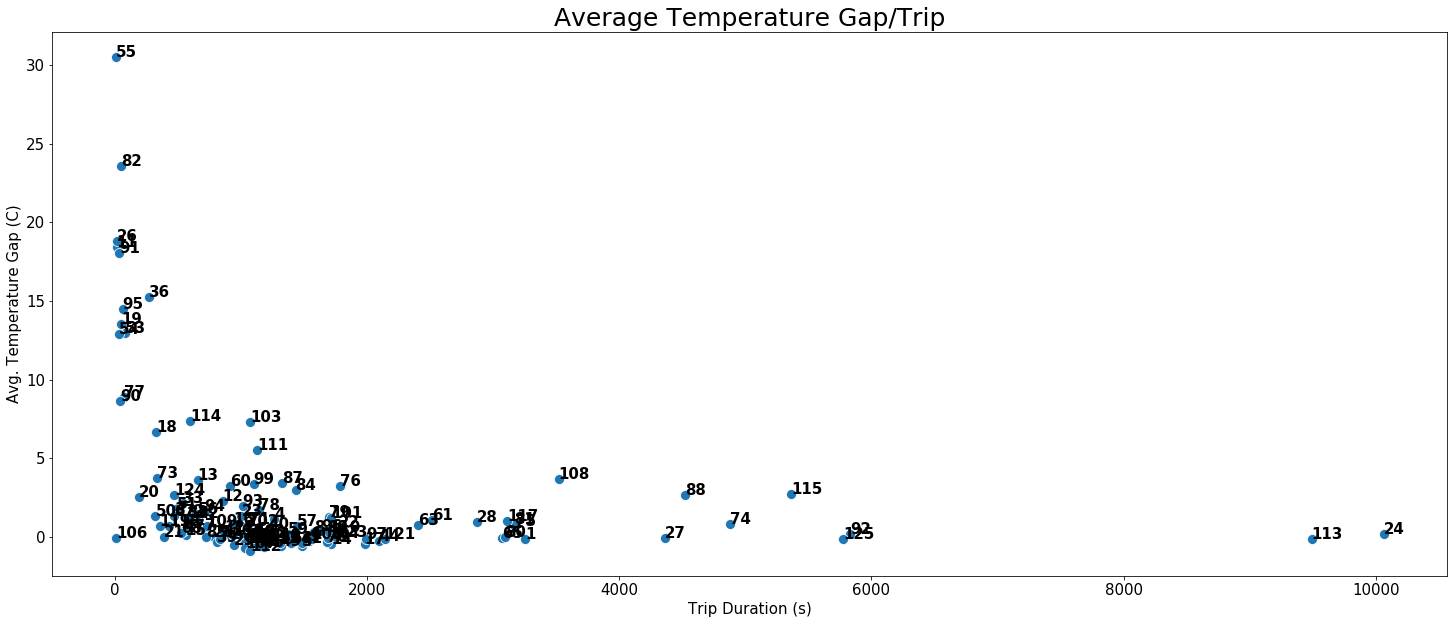

In [11]:
fig, ax = plt.subplots(figsize=(25, 10))
epoch_vs_temp_gap = pivotted_f.groupby('trip')['epoch', 'temp_gap'].agg({'epoch':lambda x: x.max() - x.min(), 'temp_gap':'mean'})
sns.scatterplot(x='epoch', y='temp_gap', data=epoch_vs_temp_gap, s=100)
plt.title('Average Temperature Gap/Trip', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Trip Duration (s)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Avg. Temperature Gap (C)', fontsize=15)
for x, y, trip in zip(epoch_vs_temp_gap['epoch'], epoch_vs_temp_gap['temp_gap'], epoch_vs_temp_gap.index):
    plt.text(x, y, str(int(trip)), color="black", fontsize=15, weight='bold')

In [66]:
# function to plot gap between actual and requested temp.
def plot_gap(df, trip, xlab='Time Elapsed (s)', ylab='Temperature (C)'):  
    fig, ax = plt.subplots(figsize=(25, 10))
    df_for_vis = pd.melt(df, id_vars=['epoch'], value_vars=['HvacEvap_Te_Actl', 'HvacEvap_Te_Rq'], var_name='evap_status', value_name='temp_gap')
    df_for_vis['time_elap'] = (df_for_vis['epoch'] - df_for_vis['epoch'].min()).astype(int)
    sns.lineplot(x="time_elap", y="temp_gap", hue="evap_status", data=df_for_vis, ax=ax, marker='o', markersize=10)
    plt.title(f'Temperature Gap (Trip {trip})', fontsize=25)
    plt.xticks(fontsize=15)
    plt.xlabel(xlab, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel(ylab, fontsize=15)
    plt.legend(prop={'size': 15})

In [67]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def show_gap_for_trip(trip=pivotted_f['trip'].unique()):
    plot_gap(pivotted_f[pivotted_f['trip'] == trip], trip)


interactive(children=(Dropdown(description='trip', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

**Aggregate Temperature Correlation vs. All Features Across All Trips**

In [12]:
# function to get df with corr matrix for each trip
def get_corr_mat_all_trips(impute=True):
    trips = pivotted_f['trip'].unique()
    temp_cols = ['temp_gap', 'HvacEvap_Te_Actl', 'HvacEvap_Te_Rq']
    if impute:
        trip_data = [pd.get_dummies(pivotted_f[pivotted_f['trip'] == trip][['epoch'] + list(pivotted_f.columns[4:])]).corr().loc[temp_cols].drop(temp_cols, axis=1) for trip in trips]
    else:
        trip_data = [pd.get_dummies(pivotted[pivotted['trip'] == trip][['epoch'] + list(pivotted.columns[4:])]).corr().loc[temp_cols].drop(temp_cols, axis=1) for trip in trips]
 
    return trip_data

corr_data_all_trips = get_corr_mat_all_trips()
corr_data_agg = pd.concat(corr_data_all_trips).reset_index().groupby('index').mean().reset_index()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


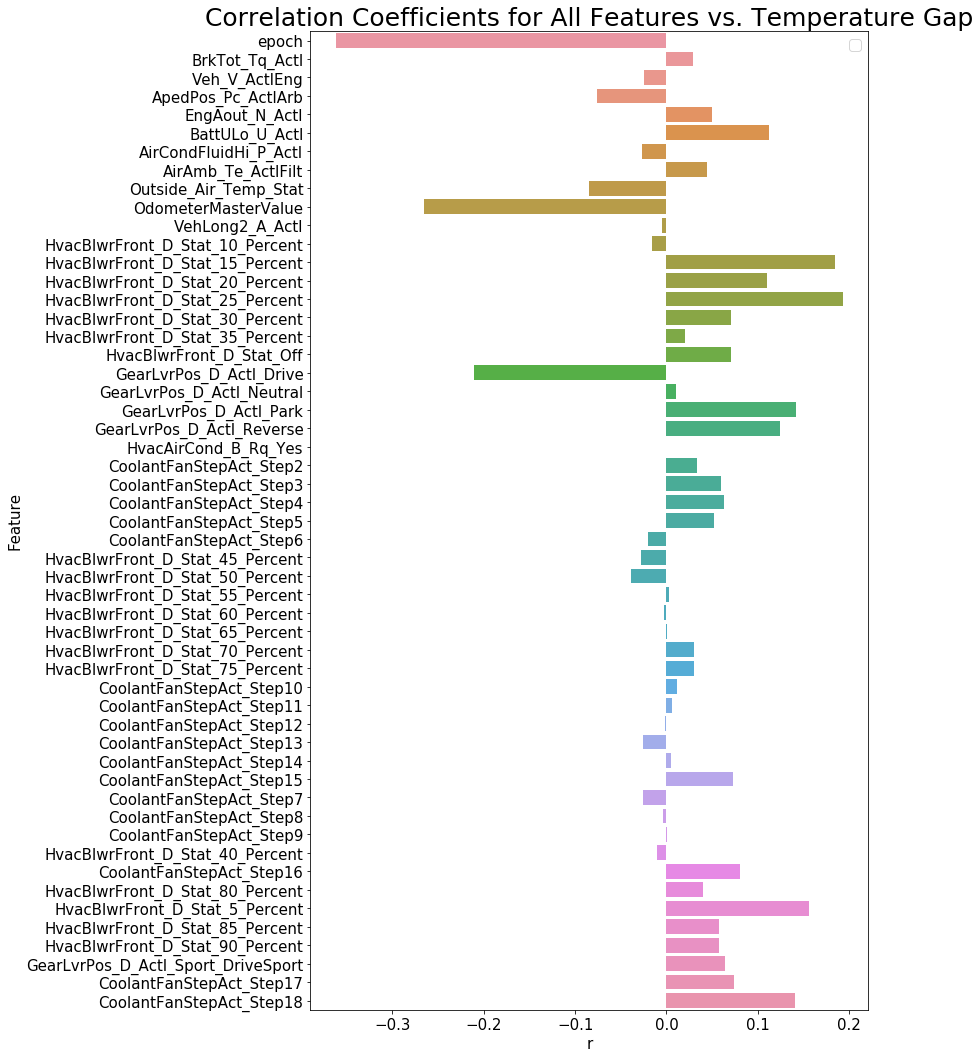

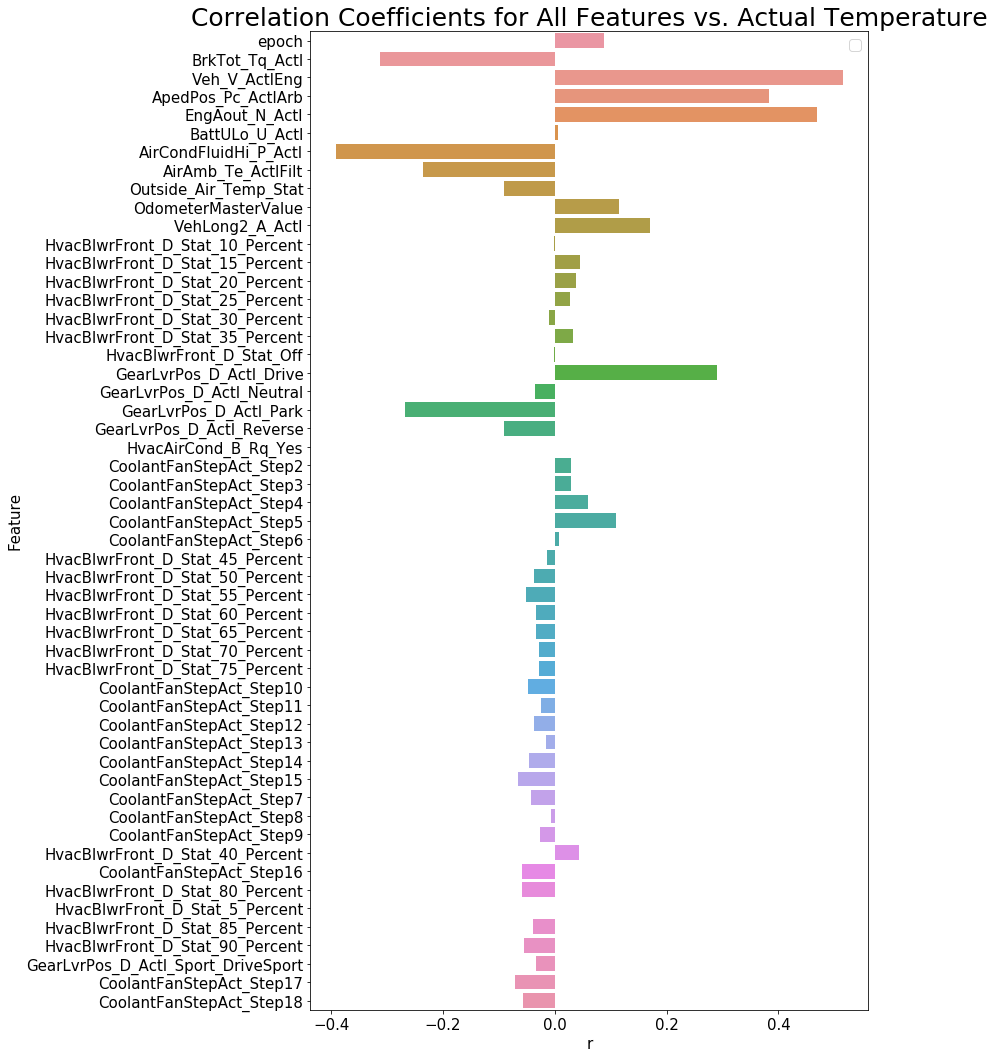

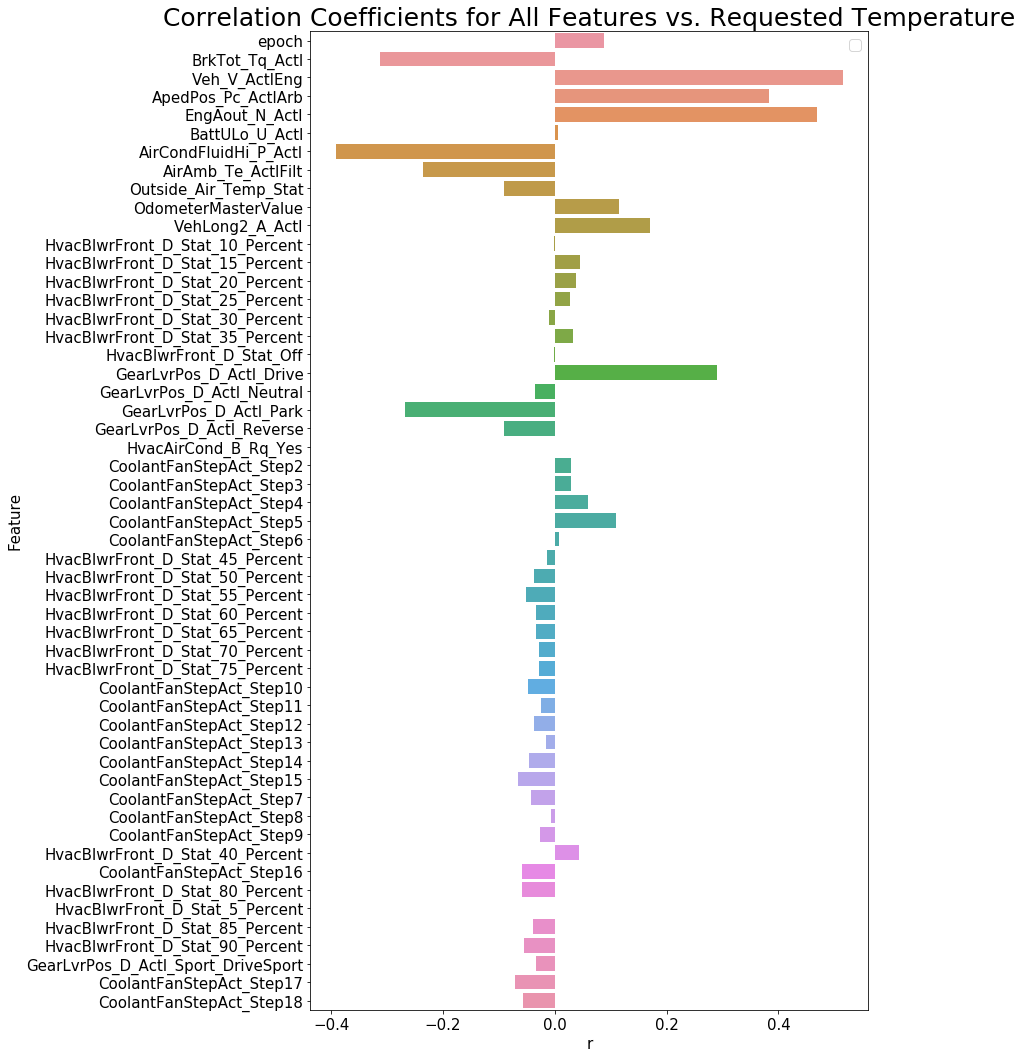

In [22]:
def make_barplot_agg_corr(x, y, title, xlab, ylab):
    fig, ax = plt.subplots(figsize=(10, 18))
    sns.barplot(x, y)
    plt.title(title, fontsize=25)
    plt.xticks(fontsize=15)
    plt.xlabel(xlab, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel(ylab, fontsize=15)
    plt.legend(prop={'size': 15})

make_barplot_agg_corr(corr_data_agg.iloc[0, 1:],corr_data_agg.columns[1:], 'Correlation Coefficients for All Features vs. Temperature Gap', 'r', 'Feature')
make_barplot_agg_corr(corr_data_agg.iloc[1, 1:],corr_data_agg.columns[1:], 'Correlation Coefficients for All Features vs. Actual Temperature', 'r', 'Feature')
make_barplot_agg_corr(corr_data_agg.iloc[1, 1:],corr_data_agg.columns[1:], 'Correlation Coefficients for All Features vs. Requested Temperature', 'r', 'Feature')

**Visualizing the Gap and Another Feature**

In [117]:
from matplotlib.lines import Line2D
import matplotlib as mpl
# function to plot gap between actual and requested temp.
def plot_vs_time(df, trip_num, feature, temp_features_to_append, xlab='Time Elapsed (s)'):
    plt.close('all')
    if pivotted_f[feature].dtype == 'O':
        df['epoch'] = (df['epoch'] - df['epoch'].min()).astype(int)
        fig, ax = plt.subplots(3, 1, figsize=(28, 22))
        ax[0].set_xlabel(xlab, fontsize=20)
        ax[1].set_xlabel(xlab, fontsize=20)
        ax[2].set_xlabel(xlab, fontsize=20)
        ax[0].tick_params(axis='both', which='major', labelsize=20)
        ax[1].tick_params(axis='both', which='major', labelsize=20)
        ax[2].tick_params(axis='both', which='major', labelsize=20)
        df['epoch'] = (df['epoch'] - df['epoch'].min()).astype(int)
        sns.lineplot(x='epoch', y='temp_gap', hue=feature, data=df, ax=ax[0], marker='o', markersize=10)
        ax[0].set_ylabel('Gap (C)', fontsize=20)
        ax[0].legend(prop={'size': 20})
        sns.lineplot(x='epoch', y='HvacEvap_Te_Actl', hue=feature, data=df, ax=ax[1], marker='o', markersize=10)
        ax[1].set_ylabel('Actual (C)', fontsize=20)
        ax[1].legend(prop={'size': 20})
        sns.lineplot(x='epoch', y='HvacEvap_Te_Rq', hue=feature, data=df, ax=ax[2], marker='o', markersize=10)
        ax[2].set_ylabel('Requested (C)', fontsize=20)
        ax[2].legend(prop={'size': 20})
        ax[0].set_title(f'Temperature vs. Time (Trip {trip_num})', fontsize=30)
        return fig
    
    else:
        fig, ax1 = plt.subplots(figsize=(38, 15))
        plt.title(f'Features vs. Time (Trip {trip_num})', fontsize=30)
        plt.xticks(fontsize=20)
        ax2 = ax1.twinx()
        df['epoch'] = (df['epoch'] - df['epoch'].min()).astype(int)
        df_for_vis = pd.melt(df, id_vars=['epoch'], value_vars=temp_features_to_append, var_name='Feature', value_name='temp')
        df_for_vis['time_elap'] = (df_for_vis['epoch'] - df_for_vis['epoch'].min()).astype(int)
        sns.lineplot(x="time_elap", y="temp", hue="Feature", data=df_for_vis, ax=ax1, marker='o', markersize=10, legend=False, palette={'HvacEvap_Te_Actl':'blue', 'temp_gap':'green', 'HvacEvap_Te_Rq':'orange'}) 
        sns.lineplot(x='epoch', y=feature, data=df, ax=ax2, marker='o', markersize=10, color='purple')
        ax1.set_ylabel('Temperature (C)', fontsize=20)
        ax1.tick_params(axis='y', which='major', labelsize=20)
        ax2.set_ylabel(feature, fontsize=20)
        ax2.tick_params(axis='y', which='major', labelsize=20)
        ax1.set_xlabel(xlab, fontsize=20)
        custom_lines = [Line2D([0], [0], lw=4, color='Blue'),
                    Line2D([0], [0], lw=4, color='orange'),
                    Line2D([0], [0], lw=4, color='green'), Line2D([0], [0], lw=4, color='Purple')]
        plt.legend(custom_lines, ['Actual', 'Requested', 'Gap', f'{feature}'], prop={'size': 20})
        return fig

In [131]:
@interact
def show_rel(save_fig=widgets.Checkbox(value=False, description='Save Plot'), trip_num=pivotted_f['trip'].unique(), feature=[col for col in pivotted_f.columns[4:] if col not in ['HvacEvap_Te_Actl', 'HvacEvap_Te_Rq', 'temp_gap', 'HvacAirCond_B_Rq']], actl=widgets.Checkbox(value=False, description='Include Actual Temperature'), rq=widgets.Checkbox(value=False, description='Include Requested Temperature'), gap=widgets.Checkbox(value=True, description='Include Gap')):
    temp_features_to_plot = []
    if actl:
        temp_features_to_plot.append('HvacEvap_Te_Actl')
    if rq:
        temp_features_to_plot.append('HvacEvap_Te_Rq')
    if gap:
        temp_features_to_plot.append('temp_gap')
    trip = pivotted_f[(pivotted_f['trip'] == trip_num)]
    trip = trip[['epoch'] + list(trip.columns[4:])]
    try:
        fig = plot_vs_time(trip, trip_num, feature, temp_features_to_plot)
        if save_fig:
            try:
                fig.savefig(f'temp_gaps/Trip{trip_num}_{feature}.png')
            except FileNotFoundError:
                print("Directory doesn't exists! Make directory called 'temp_gaps'")
    except ValueError:
        print('Feature not present in trip!')
        plt.close()

interactive(children=(Checkbox(value=False, description='Save Plot'), Dropdown(description='trip_num', options…